# Sentiment Analysis for Soccer Games (EPL) using Twitter
Author: Dixon Liang

Hi, welcome to my implementation of sentiment analysis of soccer games using Python. This project was for the class CS 410 (Text Information Systems) at the University of Illinois Urbana Champaign as part of my Masters in Computer Science curriculum. However, I would like to share it with anyone who might be interested in it. 

We will be using Tweepy to source tweets from the Twitter API and TextBlob to provide a framework for natural language processing to provide sentiment analysis. In addition, we will use PyPi's implementation of BM25Okapi to provide context of the sentiment analysis. 

Ideally, the result of this code will show the relative sentiment of a player's performance during a recent game. By using wisdom of the crowds, we hope to gain an idea of how the player performed. Using BM25Okapi, we will also be able to use relevant terms to see what might have caused sentiment to go way or another (ex. player scored a goal or provided an assist, etc.) Using PyPlot, we will also be able to visualize the results. 

This notebook will provide a run through of how the code works with the main code in my Github, providing relevant output which may be useful for anyone interested. The source code is available at my Github (https://github.com/dixonliang). Technically, this code can be used for any soccer game, but given the popularity and language barrier, EPL games are likely to provide the most meaningful results. Adjustments could be made for La Liga or Serie A using Spanish or Italian NLP. Please feel free to reach out as I welcome any collaboration as the code can be improved and applied to different sports or different applications all together :) . 


## Packages Needed: 

The two cells below provide area to install the necessary packages and import them.

We will need: Tweepy, TextBlob, Numpy, Rank_BM25, and Matplotlib.pyplot

http://docs.tweepy.org/en/latest/api.html
https://textblob.readthedocs.io/en/dev/api_reference.html
https://numpy.org/doc/
https://pypi.org/project/rank-bm25/
https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.html
    
Because we are using Twitter, we will also need access to Twitter's API. This can be gained by using a Twitter profile and requesting access for the API. A link for how to do this is provided here (http://docs.tweepy.org/en/latest/auth_tutorial.html). You will be provided four keys of strings of letters and numbers which you will need to enter in the box below: consumer key, consumer secret, access token, access token secret. 

In [1]:
# install any packages here

# pip install tweepy

In [2]:
# import necessary packages here

import tweepy # import tweepy aka Twitter API
from textblob import TextBlob # import textblob
import numpy as np # import numpy
from rank_bm25 import BM25Okapi # import BM25
import matplotlib.pyplot as plt # import plotting
plt.ion()

# authentication for Twitter

consumer_key = ""
consumer_secret = ""
access_token = ""
access_token_secret = ""

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth,wait_on_rate_limit=True)

## Setting Game Parameters

Below is where we will set the game we are interested in. The main variables to set here are the team names we are interested in searching for. Given there may be multiple names used for teams, the best choice would be for the most commonly references. The 11 starting players for each team will also need to be listed; similarily, we should use the most commonly used names for the player if they can be referred to as different names. 

Ex. team1 = "Chelsea" 

team2 = "Spurs" 

team1_Player1 = "Pulisic"

team1_Player2 = "Werner"

team1_Player3 = "Kovacic" 

... 

team2_Player1 = "Kane"

team2_Player2 = "Son"

team2_Player3 = "Aurier"

Note: Unless you have enterprise access to the Twitter API, only games within the last seven days can be accessed. The free version of the Twitter API only provides tweets within the last seven days. 

In [16]:
team1 = "Chelsea"
team2 = "Newcastle"

#team1
team1_Player1 = "Mendy"
team1_Player2 = "Rudiger"
team1_Player3 = "Zouma"
team1_Player4 = "Chilwell"
team1_Player5 = "James"
team1_Player6 = "Kante"
team1_Player7 = "Mount"
team1_Player8 = "Kovacic"
team1_Player9 = "Abraham"
team1_Player10 = "Werner"
team1_Player11 = "Ziyech"

#team2
team2_Player1 = "Joelinton"
team2_Player2 = "Saint-Maximin"
team2_Player3 = "Hayden"
team2_Player4 = "Longstaff"
team2_Player5 = "Murphy"
team2_Player6 = "Lewis"
team2_Player7 = "Clark"
team2_Player8 = "Lascelles"
team2_Player9 = "Fernandez"
team2_Player10 = "Manquillo"
team2_Player11 = "Darlow"

total_players = 11

team1_player_array = [team1_Player1, team1_Player2, team1_Player3, team1_Player4, team1_Player5, team1_Player6, team1_Player7,
team1_Player8, team1_Player9, team1_Player10, team1_Player11] # player array for Team 1

team2_player_array = [team2_Player1, team2_Player2, team2_Player3, team2_Player4, team2_Player5, team2_Player6, team2_Player7,
team2_Player8, team2_Player9, team2_Player10, team2_Player11] # player array for Team 2

team1_player_sentiment = [] # place holder array for players senitment scores
team1_player_tweets = [] # place holder for the tweets for each player
team1_player_combined = [] # place holder for the tweets for each player and sentiment

team2_player_sentiment = [] # place holder array for players senitment scores
team2_player_tweets = [] # place holder for the tweets for each player that match threshold
team2_player_combined = [] # place holder for the tweets for each player and sentiment

## Algorithm Parameters 

We will now need to set the parameters specific to the game we are interested in. We will need to set the number of tweets that we are interested in retrieving for each player. A threshold for the subjectivity of a tweet will need to be set too which will determine which tweets are used for our analysis (range from 0 to 1, with 0 being objective and 1 being subjective). Given the analysis, it's probably reasonable to allow for even the slightest subjectivity in a tweet to give us the most data to work with. 

We will also need to provide the dates from which our tweets will be sourced from. Ideally, it is best to use the day of and the day after the game. Date is to be provided in the following format "YYYY-MM-DD". 

In [17]:
### define the number of tweets we want to sort for and subjective threshold

number_of_tweets = 100 # how many tweets we want to search for
threshold = 0.10 # threshold for subjectivity [0,1]

### setting date range, ideally run day after the game

date_since = "2020-11-21"
date_until = "2020-11-22"

## Running through the algorithm for each team 

The below cells wil run through each team, retrieving the number of tweets set for each player and placing them into arrays. 

There are also some helper functions above the loops that will be used for later on. 

In [18]:
### code to sort by sentiment rating

def sentiment_element(element): # define sorting function
    return element[1]

### display the top 10 min and max sentiment tweets for a player based on team

def display_tweets(team, player_number):
    if (team == team1):
        print(team1_player_tweets[player_number-1][0:9]) # negative sentiment
        print(team1_player_tweets[player_number-1][number_of_tweets-11:number_of_tweets-1]) # positive sentiment
    else:
        print(team2_player_tweets[player_number-1][0:9]) # negative sentiment
        print(team2_player_tweets[player_number-1][number_of_tweets-11:number_of_tweets-1]) # positive sentiment
        
### PART1: Basic Sentiment Analysis without any adjustments

### Loop for Team 1 to find sentiment


for i in team1_player_array: # loop through each player
    search_words = [i, team1] # search array for each player
    tweets = tweepy.Cursor(api.search,search_words,lang="en",since=date_since,until=date_until).items(number_of_tweets) # find tweets for each player
    tweet_array = []
    sentiment_array = []
    combined_array = []

    for tweet in tweets:
        tweet_array.append(tweet.text)
        sentiment_array.append(TextBlob(tweet.text).sentiment) # append the sentiment into array

    for j in range(0,len(tweet_array)): # create combined array to sort
        combined_array.append([tweet_array[j],sentiment_array[j][0]])

    combined_array.sort(key=sentiment_element)  # sort tweet array by sentiment (remember that lowest sentiment is first)

    team1_player_tweets.append(tweet_array) # create array of just the tweets
    team1_player_combined.append(combined_array) # create array of all of the respective player tweets, which are now sorted by sentiment

    sentiment_count = 0 # want to only count sentiments that are subjective
    sentiment_total = 0 # keep track for average
    for sentiment in sentiment_array:
        if (sentiment[1] >= threshold): # set threshold for objectivity, 0 = objective, 1 = subjective
            sentiment_count = sentiment_count + 1
            sentiment_total = sentiment_total + sentiment[0]

    if (sentiment_total == 0):
        team1_player_sentiment.append([i,0,sentiment_count]) # handle 0 count
    else:
        team1_player_sentiment.append([i,sentiment_total/sentiment_count,sentiment_count])


### Loop for Team 2 to find sentiment

for i in team2_player_array: # loop through each player
    search_words = [i, team2] # search array for each player
    tweets = tweepy.Cursor(api.search,search_words,lang="en",since=date_since,until=date_until).items(number_of_tweets) # find tweets for each player
    tweet_array = []
    sentiment_array = []
    combined_array = []

    for tweet in tweets:
        tweet_array.append(tweet.text)
        sentiment_array.append(TextBlob(tweet.text).sentiment) # append the sentiment into array

    for j in range(0,len(tweet_array)): # create combined array to sort
        combined_array.append([tweet_array[j],sentiment_array[j][0]])

    combined_array.sort(key=sentiment_element)  # sort tweet array by sentiment (remember that lowest sentiment is first)

    team2_player_tweets.append(tweet_array) # create array of just the tweets
    team2_player_combined.append(combined_array) # create array of all of the respective player tweets, which are now sorted by sentiment

    sentiment_count = 0 # want to only count sentiments that are subjective
    sentiment_total = 0 # keep track for average
    for sentiment in sentiment_array:
        if (sentiment[1] >= threshold): # set threshold for objectivity
            sentiment_count = sentiment_count + 1
            sentiment_total = sentiment_total + sentiment[0]


    if (sentiment_total == 0):
        team2_player_sentiment.append([i,0,sentiment_count]) # handle 0 count
    else:
        team2_player_sentiment.append([i,sentiment_total/sentiment_count,sentiment_count])


## Plotting the Results and Displaying Sentiment Tweets

The below cells will graph the results in the form of a horizontal bar chart. The following cell will display any tweets that the user might be interested in for a specific player. 

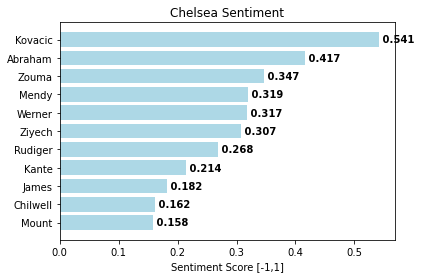

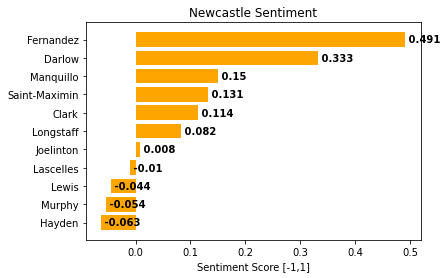

In [19]:
### sort each senitment array and organize for plotting

team1_player_sentiment.sort(key=sentiment_element)
team2_player_sentiment.sort(key=sentiment_element)

# create index for team 1
team1_Index = []
team1_Sentiment = []
for i in team1_player_sentiment:
    team1_Index.append(i[0])
    team1_Sentiment.append(round(i[1],3))

# create index for team 2
team2_Index = []
team2_Sentiment = []
for i in team2_player_sentiment:
    team2_Index.append(i[0])
    team2_Sentiment.append(round(i[1],3))


### create bar graphs for Part 1 displaying data and then save down

def plot_bar_team1_sentiment():
    fig, ax = plt.subplots()
    ax.barh(team1_Index, team1_Sentiment, color = "lightblue")
    plt.title(team1 + ' Sentiment')
    plt.xlabel('Sentiment Score [-1,1]')
    for i, v in enumerate(team1_Sentiment):
        ax.text(v, i, " " + str(v), color='black', va = 'center', fontweight='bold')
    plt.savefig('team1_sentiment.png')

plot_bar_team1_sentiment()

def plot_bar_team2_sentiment():
    fig, ax = plt.subplots()
    ax.barh(team2_Index, team2_Sentiment, color = "orange")
    plt.title(team2 + ' Sentiment')
    plt.xlabel('Sentiment Score [-1,1]')
    for i, v in enumerate(team2_Sentiment):
        ax.text(v, i, " " + str(v), color='black', va = 'center', fontweight='bold')
    plt.savefig('team2_sentiment.png')

plot_bar_team2_sentiment()

In [20]:
### display tweets for players interested in

# team 1

display_tweets("Chelsea",2)
display_tweets("Chelsea",3)

# team 2

display_tweets("Newcastle",3)
display_tweets("Newcastle",8)

['RT @SiPhillipsSport: Chelsea keep the ball for about 5 minutes, thennnnn Rudiger.', 'RT @goal: Thiago Silva ❌\nHavertz ❌\nPulisic ❌\n\nRudiger ✅\nChilwell ✅\nWerner ✅\n\nChelsea reveal their team to play Newcastle 🔵\n\n#NEWCHE https:/…', '@ChelseaFC Chelsea had a clean with Rudiger and Zouma playing together. 😉 We are winning this league', 'RT @SiPhillipsSport: Chelsea keep the ball for about 5 minutes, thennnnn Rudiger.', 'NEWCASTLE 0-2 CHELSEA: GODFREY 🗣️ "The only player wey dun improve Chelsea na Mendy, ZOUMA AND RUDIGER STILL NO GET… https://t.co/TYZOd3mZ9X', 'RT @kingmali_: @ChelseaFC MOTM kante\nLovely clean sheet Mendy\nWell done Tammy\nRudiger is not fit to be a Chelsea player PERIOD!\nEmerson is…', 'RT @SiPhillipsSport: Chelsea keep the ball for about 5 minutes, thennnnn Rudiger.', 'RT @AbsoluteChelsea: Frank Lampard says Antonio Rudiger was brilliant on his first Premier League start of the season for #Chelsea against…', "Are you more confident about Chelsea's defensive op

# Using BM25Okapi for Context

One of the most popular NLP search algorithms, which remains state of the art is BM25Okapi. 

In [21]:
### implementiation for specific terms relating to the game, ranking for BM25Okapi

positive_terms = "assist good excellent great" # search queries, positive terms
negative_terms = "poor bad miss own awful" # negative terms

## Running the BM25Okapi Algorithm 

Below is the main code for running the algorithm. 

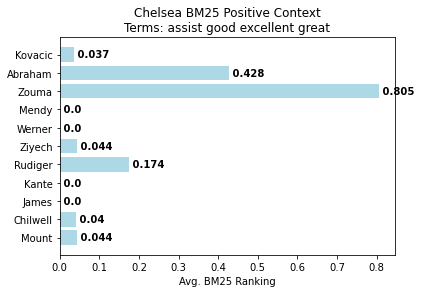

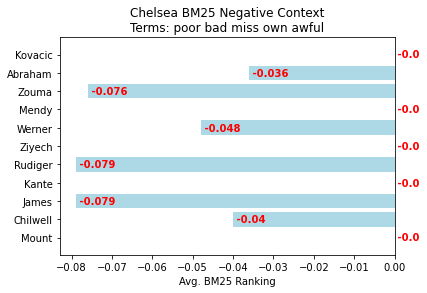

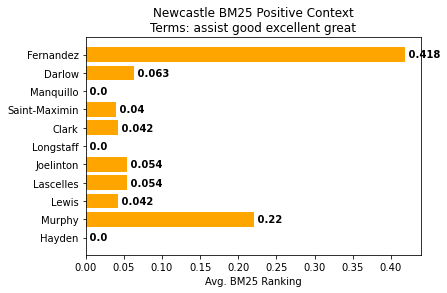

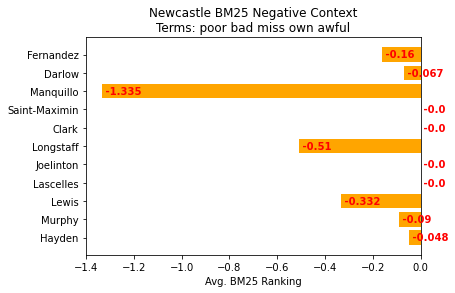

In [22]:
### implementation of BM25Okapi to rank relevant of tweets in relation the game

def rank_scores(corpus, terms): # give each tweet a score based on query
    bm25 = BM25Okapi(corpus)
    tweet_scores = bm25.get_scores(terms)
    return tweet_scores

def rank_top(corpus, terms): # show the top 10 based on query
    bm25 = BM25Okapi(corpus)
    top_10_tweets = bm25.get_top_n(terms, corpus, n=10)
    return top_10_tweets


### sentiment in relation to using BM25 as context

team1_total_tweets = []
team2_total_tweets = []
team1_positive_results = []
team2_positive_results = []
team1_negative_results = []
team2_negative_results = []

for i in range(0,len(team1_player_tweets)):
    team1_total_tweets = team1_total_tweets + team1_player_tweets[i] # combine all player tweets into one corpus
    team2_total_tweets = team2_total_tweets + team2_player_tweets[i]
total_tweets = team1_total_tweets + team2_total_tweets # combine both player tweets into one corpus
tokenized_tweets = [doc.split(" ") for doc in total_tweets] # tokenize the tweets for function

tokenized_query_positive = positive_terms.split(" ")
tokenized_query_negative = negative_terms.split(" ")

# positive array
positive_array = rank_scores(tokenized_tweets,tokenized_query_positive)
team1_positive_array = positive_array[0:number_of_tweets*total_players] # break into positive array for the two teams for sum
team2_positive_array = positive_array[number_of_tweets*total_players:len(positive_array)]

# negative array
negative_array = rank_scores(tokenized_tweets,tokenized_query_negative)
team1_negative_array = negative_array[0:number_of_tweets*total_players] # break into positive array for the two teams for sum
team2_negative_array = negative_array[number_of_tweets*total_players:len(negative_array)]

# postive tweets
team1_positive_results = np.sum(np.reshape(team1_positive_array,(total_players,number_of_tweets)),axis=1) / number_of_tweets
team2_positive_results = np.sum(np.reshape(team2_positive_array,(total_players,number_of_tweets)),axis=1) / number_of_tweets

# negative tweets
team1_negative_results = np.sum(np.reshape(team1_negative_array,(total_players,number_of_tweets)),axis=1) / -number_of_tweets
team2_negative_results = np.sum(np.reshape(team2_negative_array,(total_players,number_of_tweets)),axis=1) / -number_of_tweets

### create bar graphs for Part 2 displaying data and then save down


# reshape sum arrays for graphing

team1_positive_results = np.round(np.reshape(team1_positive_results,(1,total_players)).tolist(),3)
team2_positive_results = np.round(np.reshape(team2_positive_results,(1,total_players)).tolist(),3)
team1_negative_results = np.round(np.reshape(team1_negative_results,(1,total_players)).tolist(),3)
team2_negative_results = np.round(np.reshape(team2_negative_results,(1,total_players)).tolist(),3)


# team 1 BM25 charts

def plot_bar_team1_BM25positive():
    fig, ax = plt.subplots()
    ax.barh(team1_Index, team1_positive_results[0], color = "lightblue")
    plt.title(team1 + ' BM25 Positive Context' + '\n' + "Terms: " + positive_terms)
    plt.xlabel('Avg. BM25 Ranking')
    for i, v in enumerate(team1_positive_results[0]):
        ax.text(v, i, " " + str(v), color='black', va = 'center', fontweight='bold')
    plt.savefig('team1_BM25positive.png')

plot_bar_team1_BM25positive()

def plot_bar_team1_BM25negative():
    fig, ax = plt.subplots()
    ax.barh(team1_Index, team1_negative_results[0], color = "lightblue")
    plt.title(team1 + ' BM25 Negative Context' + '\n' + "Terms: " + negative_terms)
    plt.xlabel('Avg. BM25 Ranking')
    for i, v in enumerate(team1_negative_results[0]):
        ax.text(v, i, " " + str(v), color='red', va = 'center', fontweight='bold')
    plt.savefig('team1_BM25negative.png')

plot_bar_team1_BM25negative()


# team 2 BM25 charts

def plot_bar_team2_BM25positive():
    fig, ax = plt.subplots()
    ax.barh(team2_Index, team2_positive_results[0], color = "orange")
    plt.title(team2 + ' BM25 Positive Context' + '\n' + "Terms: " + positive_terms)
    plt.xlabel('Avg. BM25 Ranking')
    for i, v in enumerate(team2_positive_results[0]):
        ax.text(v, i, " " + str(v), color='black', va = 'center', fontweight='bold')
    plt.savefig('team2_BM25positive.png')

plot_bar_team2_BM25positive()

def plot_bar_team2_BM25negative():
    fig, ax = plt.subplots()
    ax.barh(team2_Index, team2_negative_results[0], color = "orange")
    plt.title(team2 + ' BM25 Negative Context' + '\n' + "Terms: " + negative_terms)
    plt.xlabel('Avg. BM25 Ranking')
    for i, v in enumerate(team2_negative_results[0]):
        ax.text(v, i, " " + str(v), color='red', va = 'center', fontweight='bold')
    plt.savefig('team2_BM25negative.png')

plot_bar_team2_BM25negative()

In [25]:
### display the top search tweets for each sentiment for each team

rank_top(team1_total_tweets,positive_terms) # search for top positive tweets for team 1
#rank_top(team1_total_tweets,negative_terms) # search for top negative tweets for team 1
#rank_top(team2_total_tweets,positive_terms) # search for top positive tweets for team 2
#rank_top(team2_total_tweets,negative_terms) # search for top negative tweets for team 2

['@Chelsea_Era @EBL2017 Werner was playing bumdesliga, I don’t doubt he’s got a good scoring record in that league. H… https://t.co/veBdvRxnxQ',
 "https://t.co/cTxtOa9fGf\nMendy &amp; Chilwell both had their 'worst' game in a Chelsea shirt today, and were still excel… https://t.co/gmjF62mTX3",
 '@AlexGoldberg_ Kovacic done ok today but gives the ball away too much in dangerous areas, against a better team Che… https://t.co/d0y3hpDjgX',
 '@afcjxmes Kovacic was Chelsea’s worst midfielder today, gave the ball away in dangerous areas too many times, Kante… https://t.co/rPLqctpkjc',
 "Timo Werner is 'undroppable'.\n\nN'Golo Kante is back doing what he does best.\n\nFrank Lampard is about to settle on a… https://t.co/oXxsMrxKh7",
 "Timo Werner is 'undroppable'.\n\nN'Golo Kante is back doing what he does best.\n\nFrank Lampard is about to settle on a… https://t.co/oXxsMrxKh7",
 'RT @Football__Tweet: Edouard Mendy has kept 7 clean sheets in his first 9 Chelsea games.\n\nTalk about an upgrade o

# Conclusion 

I believe this code gives a basic framework of senitment analysis for 


### Potential Improvements